# Import and settings

In [1]:
%load_ext autoreload
%autoreload 2

import os, re, gc, joblib
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import rcParams
from matplotlib.colors import ListedColormap
import seaborn as sn
import plotnine as pln
import anndata
import scanpy as sc
import scvelo as scv
import sctk as sk
import cellrank as cr
import scirpy as ir

rcParams['pdf.fonttype'] = 42
rcParams['ps.fonttype'] = 42
expr_cmap = sk.expression_colormap()
np.set_printoptions(linewidth=150)
sc.settings.verbosity = 0

In [2]:
data_root = Path('/lustre/scratch126/cellgen/team205/nh3/skin').resolve()
proj_root = Path('~/FCA_Fetal_Skin_priv/').expanduser()
os.chdir(proj_root)
!pwd

/home/jovyan/FCA_Fetal_Skin_priv


# Load data

In [3]:
tnk_ad = sc.read(Path(data_root, '20210324_vdj/fetal_skin.lymphoid_T_NK.doublet_removed_processed.20200403.TCR.h5ad'))

In [4]:
tnk_ad

AnnData object with n_obs × n_vars = 17943 × 20535
    obs: 'bh_doublet_pval', 'cell_caller', 'cluster_scrublet_score', 'doublet_pval', 'mt_prop', 'n_counts', 'n_genes', 'sanger_id', 'scrublet_score', 'chemistry', 'donor', 'gender', 'pcw', 'sorting', 'sample', 'chemistry_sorting', 'annot', 'hierarchy1', 'rachel_annot1', 'percent_mito', 'percent_ribo', 'percent_hb', 'percent_top50', 'leiden_hm_r0_1', 'leiden_hm_r0_2', 'leiden_hm_r0_3', 'leiden_hm_r0_4', 'leiden_hm_r0_5', 'leiden_bk_r0_1', 'leiden_bk_r0_2', 'leiden_bk_r0_3', 'leiden_bk_r0_4', 'leiden_bk_r0_5', 'leiden_hm_r0_4_split', 'rachel_annot2', 'leiden_hm_split1', 'rachel_annot3', 'multi_chain', 'IR_VJ_1_locus', 'IR_VJ_2_locus', 'IR_VDJ_1_locus', 'IR_VDJ_2_locus', 'IR_VJ_1_cdr3', 'IR_VJ_2_cdr3', 'IR_VDJ_1_cdr3', 'IR_VDJ_2_cdr3', 'IR_VJ_1_cdr3_nt', 'IR_VJ_2_cdr3_nt', 'IR_VDJ_1_cdr3_nt', 'IR_VDJ_2_cdr3_nt', 'IR_VJ_1_expr', 'IR_VJ_2_expr', 'IR_VDJ_1_expr', 'IR_VDJ_2_expr', 'IR_VJ_1_expr_raw', 'IR_VJ_2_expr_raw', 'IR_VDJ_1_expr_raw', '

In [7]:
full_ad = sc.read(Path(data_root, '20211022_final_figures/h5ad/fetal_skin.processed_with_norm_X_counts_layer.maternal_removed.20211029.h5ad', backed='r'))

In [8]:
full_ad

AnnData object with n_obs × n_vars = 186582 × 28885
    obs: 'sanger_id', 'chemistry', 'donor', 'gender', 'pcw', 'sorting', 'sample', 'chemistry_sorting', 'cell_caller', 'scrublet_score', 'cluster_scrublet_score', 'doublet_pval', 'bh_doublet_pval', 'n_counts', 'n_genes', 'percent_mito', 'percent_ribo', 'percent_hb', 'independent_annotation_refined', 'independent_annotation_broad1', 'independent_annotation_broad2', 'independent_annotation_broad3', 'independent_annotation_broad4', 'independent_annotation_broad5', 'joint_annotation', 'is_maternal', 'fig1b_annotation'
    var: 'gene_ids', 'mito', 'ribo', 'hb', 'n_cells', 'cc'
    uns: 'neighbors', 'neighbors_bk', 'pca'
    obsm: 'X_pca', 'X_umap', 'X_umap_bk'
    layers: 'counts'

In [9]:
full_ad.obs_names[0:4]

Index(['AAACCTGGTCAGTGGA-1-4834STDY7002879',
       'AAAGATGGTCGATTGT-1-4834STDY7002879',
       'AAAGCAAAGATGTGGC-1-4834STDY7002879',
       'AAAGTAGCAGATCGGA-1-4834STDY7002879'],
      dtype='object', name='index')

In [15]:
pan_obs = pd.read_csv(Path(data_root, '20211022_final_figures/PAN.A01.v01.entire_data_normalised_log.20210429.full_obs.annotated.clean.csv.gz', index_col=1))

In [19]:
pan_obs.index = pan_obs[pan_obs.columns[0]]

In [20]:
pan_obs.index = (pd.Series(pan_obs.index).str.rpartition('-')[2] + '-1-' + pd.Series(pan_obs.index).str.rpartition('-')[0]).values

In [21]:
def read_gdTCR(vdj_id, gex_id):
    input_tsv = Path(data_root, f'data/vdj/gdTCR/{vdj_id}.hiconf_contig_igblast_db-pass.tsv')
    gdtcr_df = pd.read_csv(input_tsv, sep='\t', index_col=0)
    out_tsv = gdtcr_df.groupby('cell_id').agg(
        gd_v_call=pd.NamedAgg(column='v_call', aggfunc=lambda x: '/'.join(x.unique().astype(str))),
        gd_d_call=pd.NamedAgg(column='d_call', aggfunc=lambda x: '/'.join(x.unique().astype(str))),
        gd_j_call=pd.NamedAgg(column='j_call', aggfunc=lambda x: '/'.join(x.unique().astype(str))),
        gd_c_call=pd.NamedAgg(column='c_call', aggfunc=lambda x: '/'.join(x.unique().astype(str))),
        gd_n_productive=pd.NamedAgg(column='productive', aggfunc=lambda x: (x=='T').sum())
    )
    out_tsv.index = pd.Series(out_tsv.index).astype(str) + f'-{gex_id}'
    return out_tsv

In [23]:
gdtcr_inputs = pd.read_csv(Path(data_root, '20211022_final_figures/gdTCR_metadata_02082021.csv'), index_col=0)

In [24]:
gdtcr_inputs.head()

,GDTCR,GDTCR_sample,GEX file,GDTCR_mapping,sample
0,WSSS_F_Imm10424040,F41_LI_45P_GDTCR,FCAImmP7555856,/archive/HCA/10X-VDJ/$SAMPLE/dandelion/dandeli...,F41_LI_45P_5GEX
1,WSSS_F_Imm10424041,F41_SK_45P_GDTCR,FCAImmP7555858,NaN,F41_SK_45P_5GEX
2,WSSS_F_Imm10424042,F41_TH_45P_GDTCR,FCAImmP7555860,NaN,F41_TH_45P_5GEX
3,WSSS_F_Imm10424043,F41_BM_45P_GDTCR,FCAImmP7555862,NaN,F41_BM_45P_5GEX
4,WSSS_F_Imm10424044,F45_LI_45P_GDTCR,FCAImmP7579226,NaN,F45_LI_45P_5GEX


In [25]:
gdtcr_dfs = [read_gdTCR(row.GDTCR, row['GEX file']) for i, row in gdtcr_inputs.loc[gdtcr_inputs.GDTCR_sample.str.contains('_SK_'), ['GDTCR', 'GEX file']].iterrows()]    

In [26]:
gdtcr_df = pd.concat(gdtcr_dfs)

In [27]:
gdtcr_df.head()

,gd_v_call,gd_d_call,gd_j_call,gd_c_call,gd_n_productive
cell_id,,,,,
AAACGGGAGTACGCCC-1-FCAImmP7555858,TRDV2*01,TRDD3*01,TRDJ2*01,TRDC,0
AACGTTGTCATCGCTC-1-FCAImmP7555858,TRAV36/DV7*01,TRDD2*01,TRDJ2*01,TRDC,1
AACTGGTAGTAGGTGC-1-FCAImmP7555858,TRGV9*01/TRDV2*03,nan/TRDD3*01,TRGJP*01/TRDJ1*01,TRGC1/TRDC,2
ACCCACTAGTGTCCCG-1-FCAImmP7555858,TRGV9*01/TRDV2*03,nan/TRDD3*01,TRGJP*01/TRDJ1*01,TRGC1/TRDC,2
ACCTTTATCAACCAAC-1-FCAImmP7555858,TRDV2*03,TRDD3*01,TRDJ1*01,TRDC,1


# Process

In [28]:
tnk_ad.obs_names.isin(gdtcr_df.index).sum()

650

In [29]:
np.all(tnk_ad.obs.merge(gdtcr_df, how='left', left_index=True, right_index=True).index == tnk_ad.obs_names)

True

In [30]:
tnk_ad.obs = tnk_ad.obs.merge(gdtcr_df, how='left', left_index=True, right_index=True)
tnk_ad.obs['has_gdir'] = (tnk_ad.obs['gd_n_productive'] > 0)
tnk_ad.obs['has_gdir'] = tnk_ad.obs['has_gdir'].astype('category')
tnk_ad.obs.loc[tnk_ad.obs.gd_n_productive.astype(str)=='nan', 'has_gdir'] = np.nan
tnk_ad.obs['has_gdir'] = tnk_ad.obs['has_gdir'].astype('category')
tnk_ad.obs['gd_n_productive'] = tnk_ad.obs['gd_n_productive'].astype('category')

In [31]:
gdTCR_samples = pd.Series(gdtcr_df.index).str.rpartition('-')[2].unique()

In [32]:
tnk_ad.obs = tnk_ad.obs.merge(pan_obs[['anno_lvl_2_final_clean']], how='left', left_index=True, right_index=True)
tnk_ad.obs['anno_lvl_2_final_clean'] = tnk_ad.obs['anno_lvl_2_final_clean'].astype(str).astype('category')

In [33]:
tnk_ad.obs = tnk_ad.obs.merge(full_ad.obs[['independent_annotation_refined', 'joint_annotation', 'fig1b_annotation']], how='left', left_index=True, right_index=True)

In [34]:
for col_name in ['independent_annotation_refined', 'joint_annotation', 'fig1b_annotation']:
    tnk_ad.obs[col_name].cat.remove_unused_categories(inplace=True)

# Plot

... storing 'gd_v_call' as categorical
... storing 'gd_d_call' as categorical
... storing 'gd_j_call' as categorical
... storing 'gd_c_call' as categorical
/home/jovyan/my-conda-envs/FCA_base/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:365: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored


ValueError: negative indices not supported

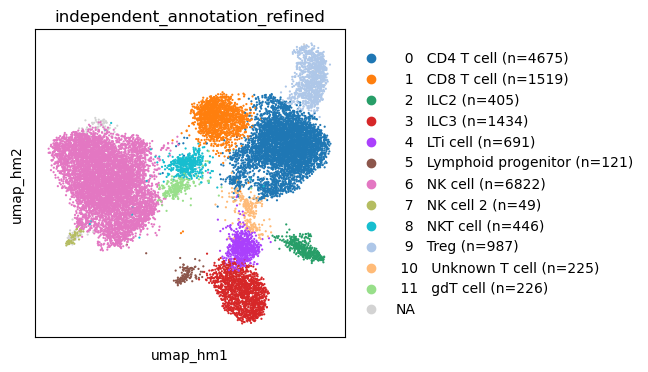

In [35]:
sk.plot_embedding(tnk_ad, basis='umap_hm', groupby='independent_annotation_refined', add_outline=False, size=10, annot='full');

/home/jovyan/my-conda-envs/FCA_base/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:365: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored


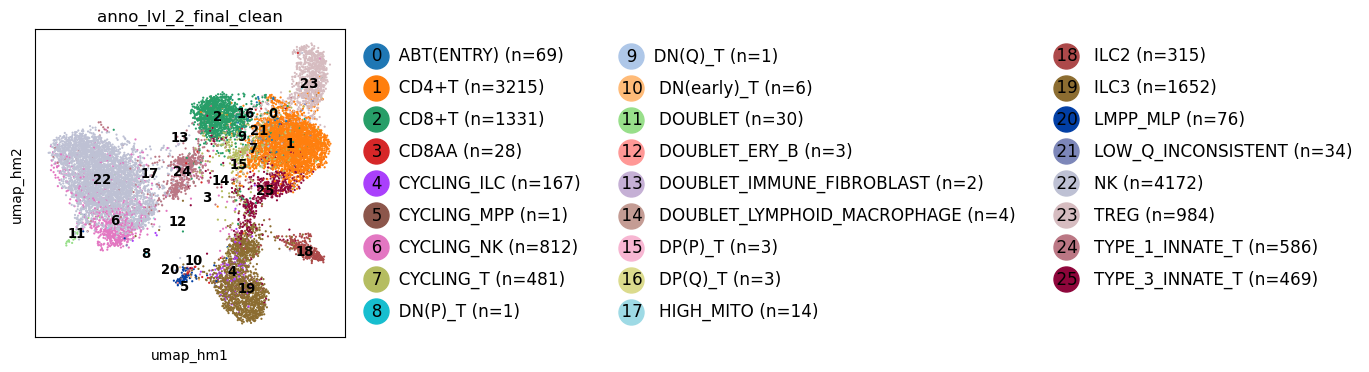

In [36]:
sk.plot_embedding(tnk_ad[tnk_ad.obs.anno_lvl_2_final_clean!='nan'].copy(), basis='umap_hm', groupby='anno_lvl_2_final_clean', add_outline=False, size=10, annot='full');

In [37]:
sk.cross_table(tnk_ad, 'anno_lvl_2_final_clean', 'independent_annotation_refined')

independent_annotation_refined,CD4 T cell,CD8 T cell,ILC2,ILC3,LTi cell,Lymphoid progenitor,NK cell,NK cell 2,NKT cell,Treg,Unknown T cell,gdT cell
anno_lvl_2_final_clean,,,,,,,,,,,,
ABT(ENTRY),48,21,0,0,0,0,0,0,0,0,0,0
CD4+T,3133,29,3,0,2,1,1,0,0,44,2,0
CD8+T,63,1236,0,0,1,0,1,0,18,1,9,2
CD8AA,8,1,1,3,0,9,0,0,5,1,0,0
CYCLING_ILC,1,0,0,128,33,1,3,0,0,0,1,0
CYCLING_MPP,0,0,0,0,0,1,0,0,0,0,0,0
CYCLING_NK,4,1,1,5,11,4,759,0,17,1,3,6
CYCLING_T,332,78,8,1,9,0,4,0,12,6,30,1
DN(P)_T,0,0,0,0,0,1,0,0,0,0,0,0


In [38]:
sk.cross_table(tnk_ad, 'independent_annotation_refined', 'anno_lvl_2_final_clean', normalise='x', plot=True, figsize=(8, 3));

TypeError: cross_table() got an unexpected keyword argument 'plot'

In [39]:
tnk_ad0 = tnk_ad[tnk_ad.obs.sanger_id.isin(gdTCR_samples)].copy()

In [40]:
tnk_ad1 = tnk_ad0[tnk_ad0.obs.has_gdir == 1].copy()

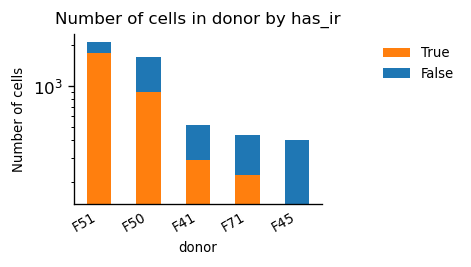

In [41]:
ir.pl.group_abundance(tnk_ad0, groupby='donor', target_col='has_ir', log=True);

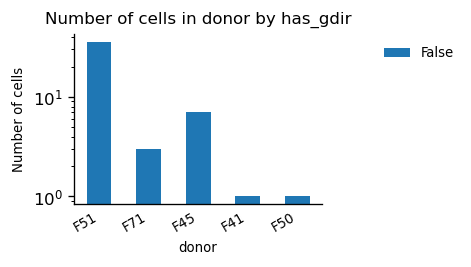

In [42]:
ir.pl.group_abundance(tnk_ad0, groupby='donor', target_col='has_gdir', log=True);

/home/jovyan/my-conda-envs/FCA_base/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:344: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
/home/jovyan/my-conda-envs/FCA_base/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:353: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
/home/jovyan/my-conda-envs/FCA_base/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:365: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored


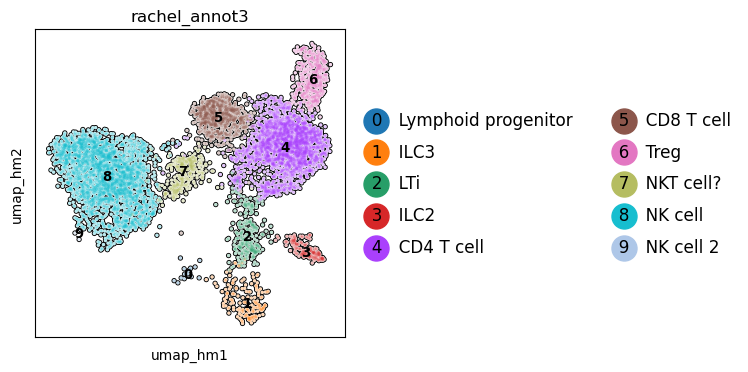

In [44]:
sk.plot_embedding(tnk_ad0, save='figures/final/fig4A', basis='umap_hm', groupby='rachel_annot3', add_outline=True, alpha=0.3, size=20);

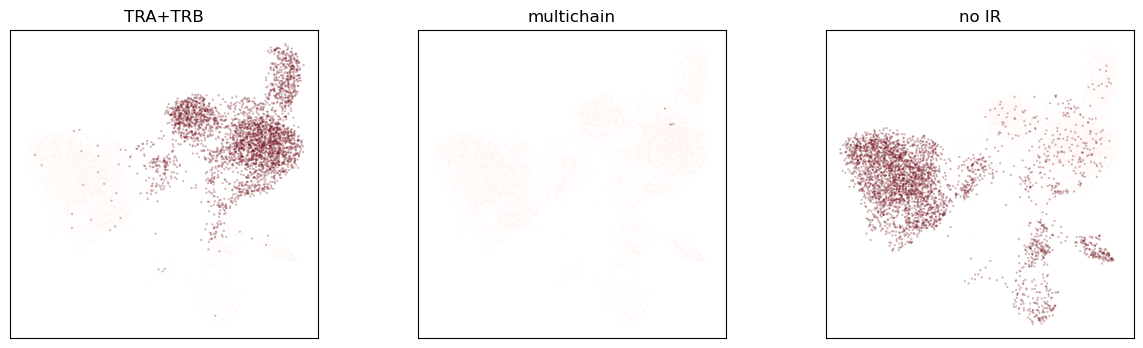

In [45]:
sk.set_figsize((4, 4))
sk.highlight(tnk_ad0, basis='umap_hm', groupby='receptor_subtype', add_outline=False, alpha=0.3, size=10)

In [46]:
sk.set_figsize((4, 4))
sk.highlight(tnk_ad0, basis='umap_hm', groupby='has_gdir', add_outline=False, size=10)

ValueError: Item wrong length 2 instead of 6824.

In [ ]:
sk.set_figsize((4, 4))
sk.highlight(tnk_ad0, basis='umap_hm', groupby='gd_n_productive', add_outline=False, size=10)

In [ ]:
tnk_ad0.obs.loc[tnk_ad0.obs.gd_n_productive==2, 'gd_v_call'].value_counts()

In [ ]:
sk.set_figsize((4, 4))
sk.plot_genes(tnk_ad0, basis='umap_hm', genes=['TRDV2', 'TRGV9'], size=5)

In [ ]:
sk.set_figsize((4, 4))
sk.pl.violin(tnk_ad0[tnk_ad0.obs.rachel_annot3=='NKT cell?'], ['TRDV2', 'TRGV9'], groupby='has_ir')

In [ ]:
sk.set_figsize((2, 4))
ir.pl.group_abundance(tnk_ad1, groupby='rachel_annot3', target_col='gd_n_productive', normalize=True);

In [ ]:
sk.set_figsize((2, 4))
ir.pl.group_abundance(tnk_ad0, groupby='rachel_annot3', target_col='gd_n_productive', normalize=True);

In [ ]:
sk.set_figsize((2, 4))
ir.pl.group_abundance(tnk_ad0, groupby='rachel_annot3', target_col='receptor_subtype', normalize=True);

In [ ]:
# tnk_ad.write('fetal_skin.lymphoid_T_NK.doublet_removed_processed.20200403.TCR_gdTCR.h5ad', compression='lzf')